# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

## Project
---

Install packages that are not part of the basic virtual environment defined on the ReadMe.

In [1]:
%pip install datasets
%pip install soundfile
%pip install librosa
%pip install transformers
%pip install accelerate
%pip install evaluate
%pip install gc
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requir

Import relevant packages

In [2]:
from datasets import load_dataset, Audio,DatasetDict, Dataset, concatenate_datasets
import numpy as np
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer,AutoConfig
import evaluate
import torch
import gc
from sklearn import metrics
import matplotlib.pyplot as plt
import torchaudio
from torchaudio.io import AudioEffector, CodecConfig
from torchaudio.utils import download_asset
from IPython.display import Audio as display_Audio
import torchaudio.functional as F
import torchaudio.transforms as T
import pandas as pd
from tqdm import tqdm
import optuna

In [3]:
SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")

SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)


SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

# Apply effects
def apply_effect(waveform, sample_rate, effect, base_path, key_effect, is_pace_changer = False):
    effector = torchaudio.io.AudioEffector(effect=effect)
    new_wf = effector.apply(waveform, sample_rate)
    max_length = 30.0
    AST_sr = 16000
    if is_pace_changer:
      length=int((AST_sr/sample_rate)*max_length) #sampling_rate here isn't 16000 or 22050, could be even 8000. cause Torchaudio.load() is automatic.
      end=np.random.randint(length,waveform.shape[0]) #Are you sure it gives 30s?
      new_wf = new_wf[(end-length):end]
    new_path = base_path.replace(".wav",f".{key_effect}.wav")
    torchaudio.save(new_path, new_wf, sample_rate, channels_first=False)
    return new_path

def apply_noise(waveform, strength_coeff = 0.010):
  noise = torch.zeros(len(waveform),dtype=torch.float64)
  noise = strength_coeff * torch.randn(len(waveform))
  noise = noise + waveform
  return noise

def apply_room(waveform):
  new_wf = F.fftconvolve(waveform, rir)
  return new_wf

def apply_pitch(waveform, sr):
  return F.pitch_shift(waveform,sample_rate, 4)

def show(result,sr, *, stereo=False):
    figsize = (6.4, 2.1 if stereo else 1.2)
    num_channels = result.size(1)
    f, ax = plt.subplots(num_channels, 1, squeeze=False, figsize=figsize, sharex=True)
    for i in range(num_channels):
        ax[i][0].specgram(result[:, i], Fs=sr)
    f.set_tight_layout(True)
    return result

def Audio_Augmentation(dataset):
  features = dataset.features
  new_data = {"file":[],"audio":[],"genre":[]}
  for i in tqdm(range(len(dataset))):
  # prev_state = 0.0
  # for i in range(len(dataset)):
  #   done = i / len(dataset)
  #   if (done*100)%10 != (prev_state*100)%10:
  #     print(f"Augmentation {done*100}% done")
    file = dataset[i]
    waveform , sr = torchaudio.load(file['file'], channels_first=False)
    fast_path = apply_effect(waveform,sr,f"atempo={np.random.randint(low=16,high=20)/10}",file["file"],"fast", is_pace_changer=True)
    slow_path = apply_effect(waveform,sr,f"atempo={np.random.randint(low=5,high=9)/10}",file["file"],"slow", is_pace_changer=True)
    highpass_path = apply_effect(waveform,sr,f"highpass=frequency={np.random.randint(low=1400,high=1600)}", file["file"], "highpass")
    lowpass_path = apply_effect(waveform,sr,f"lowpass=frequency={np.random.randint(low=900,high=1100)}", file["file"], "lowpass")
    echo_path = apply_effect(waveform,sr,"aecho=in_gain=0.8:out_gain=0.88:delays=60:decays=0.4", file["file"], "echo")
    mix_effect = ",".join(
    [
        f"lowpass=frequency={np.random.randint(low=500,high=800)}:poles=1",  # apply single-pole lowpass filter
        f"atempo={np.random.randint(low=6,high=10)/10}",  # reduce the speed
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
        # Applying echo gives some dramatic feeling
    ],
)
    mix_path = apply_effect(waveform,sr,mix_effect, file["file"],"mix", is_pace_changer=True)
    new_paths = [highpass_path, lowpass_path, echo_path]
    #new_paths = [fast_path, slow_path, highpass_path, lowpass_path, echo_path]
    #new_paths = [fast_path, slow_path, highpass_path, lowpass_path, echo_path, mix_path]
    new_data["file"] += new_paths
    new_data["audio"] += [{"path":n_path}for n_path in new_paths]
    new_data["genre"] += [file["genre"]]*len(new_paths)
    new_data_df = pd.DataFrame(new_data)
    # noise_wf = apply_noise(waveform,sr)
    #pitch_wf = apply_pitch(waveform,sr)
    #show(pitch_wf,sr)
    #room_wf = apply_room(waveform)
    #show(room_wf,sr)
    # show(noise_wf,sr)
    # break
    # prev_stat = done
  new_data_df = pd.DataFrame(new_data)
  new_data_dataset = Dataset.from_pandas(new_data_df).cast(features)
  new_dataset = concatenate_datasets([dataset, new_data_dataset])
  new_dataset.save_to_disk("updated_gtzan")
  return new_dataset

100%|██████████| 427k/427k [00:00<00:00, 16.1MB/s]
100%|██████████| 31.3k/31.3k [00:00<00:00, 78.1MB/s]
100%|██████████| 53.2k/53.2k [00:00<00:00, 11.3MB/s]
100%|██████████| 78.2k/78.2k [00:00<00:00, 13.2MB/s]


Get gtzan audio files and their corresponding labels from the Hugging Face Hub and split the dataset into training, validation and test sets.

In [4]:
gtzan = load_dataset("marsyas/gtzan", "all",trust_remote_code=True)
train_rest = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.2)
aug_train_set = Audio_Augmentation(train_rest["train"]).shuffle()
val_test = train_rest["test"].train_test_split(seed=42, shuffle=True, test_size=0.5)
gtzan=DatasetDict({'train': aug_train_set,'val': val_test["train"],'test': val_test["test"]})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

100%|██████████| 799/799 [07:05<00:00,  1.88it/s]


Casting the dataset:   0%|          | 0/2397 [00:00<?, ? examples/s]

Saving the dataset (0/9 shards):   0%|          | 0/3196 [00:00<?, ? examples/s]

Get AST feature extractor which:
1. Extracts mel-filter bank features from raw speech.
2. Pads/truncates the features to a fixed length.
3. Normalizes the features(Substracting mean and dividing by the standard deviation).

In [5]:
model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Resample the dataset according to the pretrained AST sample rate.

In [6]:
sampling_rate = feature_extractor.sampling_rate
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

Apply AST feature extractor to the dataset.

In [7]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)

Map:   0%|          | 0/3196 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Obtain the label mappings from the dataset.

In [8]:
id2label_fn = gtzan["train"].features["genre"].int2str
print(gtzan_encoded)
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")
id2label = {
    i: id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

DatasetDict({
    train: Dataset({
        features: ['genre', 'input_values'],
        num_rows: 3196
    })
    val: Dataset({
        features: ['genre', 'input_values'],
        num_rows: 100
    })
    test: Dataset({
        features: ['genre', 'input_values'],
        num_rows: 100
    })
})


Create accuracy calculation function.

In [9]:
metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Get, adjust and train the AST pretrained model.

In [10]:
gc.collect()
torch.cuda.empty_cache()

num_labels = len(id2label)
#Get pretrained model
model = AutoModelForAudioClassification.from_pretrained(model_id)
model.generation_config=AutoConfig.from_pretrained(model_id)
model.generation_config.id2label=id2label
model.generation_config.label2id=label2id
#Adjust model
model.requires_grad_(False)
model.num_labels=num_labels
model.classifier.dense= torch.nn.Linear(model.classifier.dense.in_features,num_labels)
#Define hyperparameters
model_name = model_id.split("/")[-1]
batch_size = 64
gradient_accumulation_steps = 1
num_train_epochs = 50
training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
    save_total_limit=5,
    report_to='tensorboard',
)
#Train model
trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_encoded["train"].with_format("torch"),
    eval_dataset=gtzan_encoded["val"].with_format("torch"),
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
train_results =trainer.train()
trainer.save_model('Best_Model')


config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,2.245300,2.138369,0.150000
2,2.047700,2.010273,0.240000
3,1.836100,1.822671,0.400000
4,1.625100,1.596377,0.500000
5,1.382700,1.363882,0.620000
6,1.161800,1.158511,0.670000
7,1.037900,1.010228,0.710000
8,0.920000,0.904463,0.740000
9,0.805800,0.818212,0.800000
10,0.742500,0.764490,0.800000


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generatio

In [11]:
# # Optuna:
# def objective(trial: optuna.Trial):
#   training_args = TrainingArguments(
#     f"{model_name}-finetuned-gtzan",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=trial.suggest_loguniform("learning_rate", low=1e-6, high=1e-4),
#     per_device_train_batch_size=trial.suggest_loguniform("per_device_train_batch_size", low=1e-6, high=1e-4),
#     gradient_accumulation_steps=gradient_accumulation_steps,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=num_train_epochs,
#     warmup_ratio=0.1,
#     logging_steps=5,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     fp16=True,
#     push_to_hub=False,
#     save_total_limit=5,
#     report_to='tensorboard',
# )
#   #Train model
#   trainer = Trainer(
#       model,
#       training_args,
#       train_dataset=gtzan_encoded["train"].with_format("torch"),
#       eval_dataset=gtzan_encoded["val"].with_format("torch"),
#       tokenizer=feature_extractor,
#       compute_metrics=compute_metrics,
#   )
#   train_results =trainer.train()

# #trainer.save_model('Best_Model')

# HuggingFace has Optuna interface part of Trainer API but the objective function is unclear.

# def optuna_hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64, 128]),
#         "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [16, 32, 64, 128]),
#         "gradient_accumulation_steps" : trial.suggest_categorical("gradient_accumulation_steps", [1,2,3,4]),
#     }

# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     backend="optuna",
#     hp_space=optuna_hp_space,
#     n_trials=20,
#     compute_objective=compute_objective,
# )
# best_trial.save_model('Best_Model')
# # We want to minimize the loss!
# study = optuna.create_study(study_name='hyper-parameter-search', direction='minimize')

# # Optimize the objective using 5 different trials
# study.optimize(func=objective, n_trials=15)

# # Gives the best loss value
# print(study.best_value)

# # Gives the best hyperparameter values to get the best loss value
# print(study.best_params)

# # Return info about best Trial such as start and end datetime, hyperparameters
# print(study.best_trial)

Calculate test metrics

{'test_loss': 0.5592243671417236, 'test_accuracy': 0.87, 'test_runtime': 5.2464, 'test_samples_per_second': 19.061, 'test_steps_per_second': 0.381}


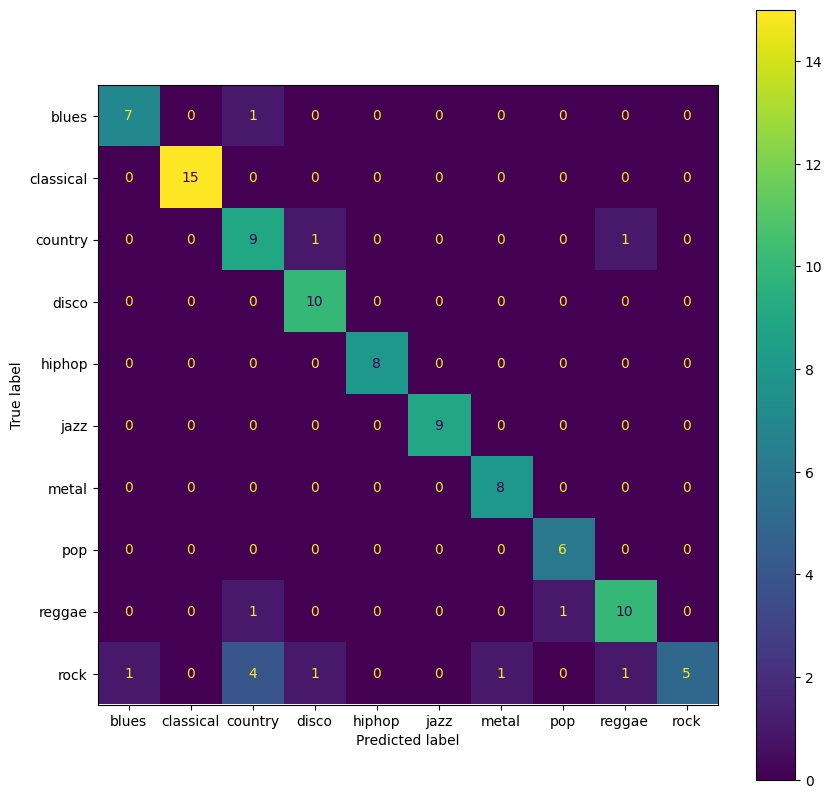

In [13]:
pred=trainer.predict(gtzan_encoded["test"].with_format("torch"))
print(pred.metrics)
confusion_matrix=metrics.confusion_matrix(pred.label_ids, np.argmax(pred.predictions, axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(label2id.keys()))
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
fig.savefig('Test_confusion_matrix.jpg')
#fig.savefig('images/Test_confusion_matrix.jpg')
plt.show()